In [150]:
import csv

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import time


RANDOM_SEED = 42

In [151]:
import numpy as np

# Load the data from both CSV files
data_to_replace = np.loadtxt("camera_data/hand_landmarks_joren_dad.csv", delimiter=',', dtype='float32')
replacement_data = np.loadtxt('hand_landmarks_h.csv', delimiter=',', dtype='float32')

# Filter the rows from replacement_data where the first column equals 7
replacement_rows = replacement_data[replacement_data[:, 0] == 7]

# Replace the rows in data_to_replace where the first column equals 7 with the filtered rows
data_to_replace[data_to_replace[:, 0] == 7] = replacement_rows

# Save the updated data_to_replace to a new CSV file
np.savetxt('updated_data.csv', data_to_replace, delimiter=',', comments='')

In [152]:
dataset = 'data_glove/Data_joren.csv'
dataset_original = 'data_glove/Data_joren.csv'
dataset_test = 'data_glove/glove_test_data.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier_glove.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier_glove.tflite'

In [153]:
NUM_CLASSES = 24

In [154]:
arr = pd.read_csv(dataset, header=None, delimiter=";")
# check the shape
input_shape = arr.shape
print(arr.iloc[0])
print(arr.iloc[1])
print(f"The input shape of your array is: {input_shape}")

0    0,0,0,0,3.519914,0.050033,3.621713,6.846703,-2...
Name: 0, dtype: object
0    0,0,0,0,3.519914,0.050033,3.621713,6.847597,-2...
Name: 1, dtype: object
The input shape of your array is: (9600, 1)


In [155]:
#X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, 365)))
X_dataset_original = X_dataset = np.loadtxt(dataset_original, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)

X_test = np.loadtxt(dataset_test, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
y_test = np.loadtxt(dataset_test, delimiter=',', dtype='int32', usecols=(0))

In [156]:
print(X_dataset.shape)
print(X_dataset_original.size)

(9600, 172)
1651200


In [157]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

C:\Users\zomaa\IdeaProjects\master\venv\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [158]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

C:\Users\zomaa\IdeaProjects\master\venv\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [159]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_17 (Reshape)            │ (None, 172, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 172, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 86, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 86, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_44 (Conv1D)              │ (None, 43, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_44 (MaxPooling1D) │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │       688,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 755,416 (2.88 MB)

 Trainable params: 755,416 (2.88 MB)

 Non-trainable params: 0 (0.00 B)

In [160]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [161]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [162]:
start_time = time.time()
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)
stop_time = time.time()
training_time=stop_time-start_time
print("training time: ",training_time,"seconds")

Epoch 1/1000
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1126 - loss: 6.7172
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.1174 - loss: 6.5767 - val_accuracy: 0.5969 - val_loss: 1.5735
Epoch 2/1000
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4402 - loss: 2.0235
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4430 - loss: 2.0187 - val_accuracy: 0.8278 - val_loss: 0.7196
Epoch 3/1000
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6721 - loss: 1.2345
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6726 - loss: 1.2331 - val_accuracy: 0.8830 - val_loss: 0.4421
Epoch 4/1000
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7433 - loss: 1.0839
Epoch 4: saving model to model/keypoint_classifier/keyp

In [169]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)
start_time=time.time()
model.predict(X_test[0:1])
stop_time = time.time()
evaluation_time=stop_time-start_time
print("evaluation time: ",evaluation_time*1000,"ms")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8285 - loss: 2.4731
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
evaluation time:  48.09427261352539 ms


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


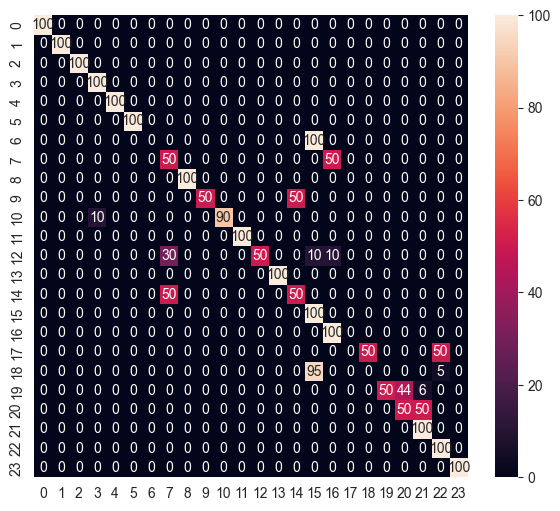

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       0.91      1.00      0.95       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       0.00      0.00      0.00       100
           7       0.38      0.50      0.43       100
           8       1.00      1.00      1.00       100
           9       1.00      0.50      0.67       100
          10       1.00      0.90      0.95       100
          11       1.00      1.00      1.00       100
          12       1.00      0.50      0.67       100
          13       1.00      1.00      1.00       100
          14       0.50      0.50      0.50       100
          15       0.33      1.00      0.49       100
          16       0.62      1.00      0.77       100
     

C:\Users\zomaa\IdeaProjects\master\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zomaa\IdeaProjects\master\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zomaa\IdeaProjects\master\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [164]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

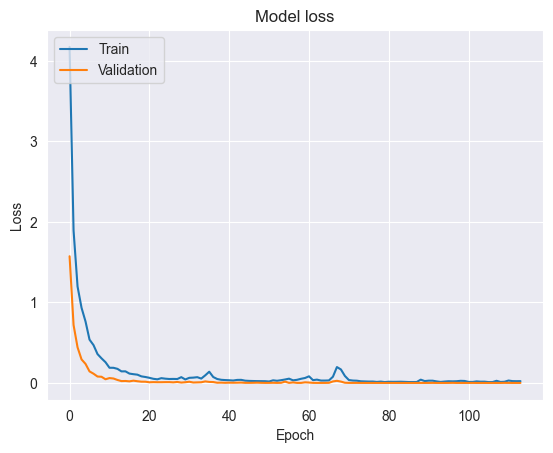

In [165]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

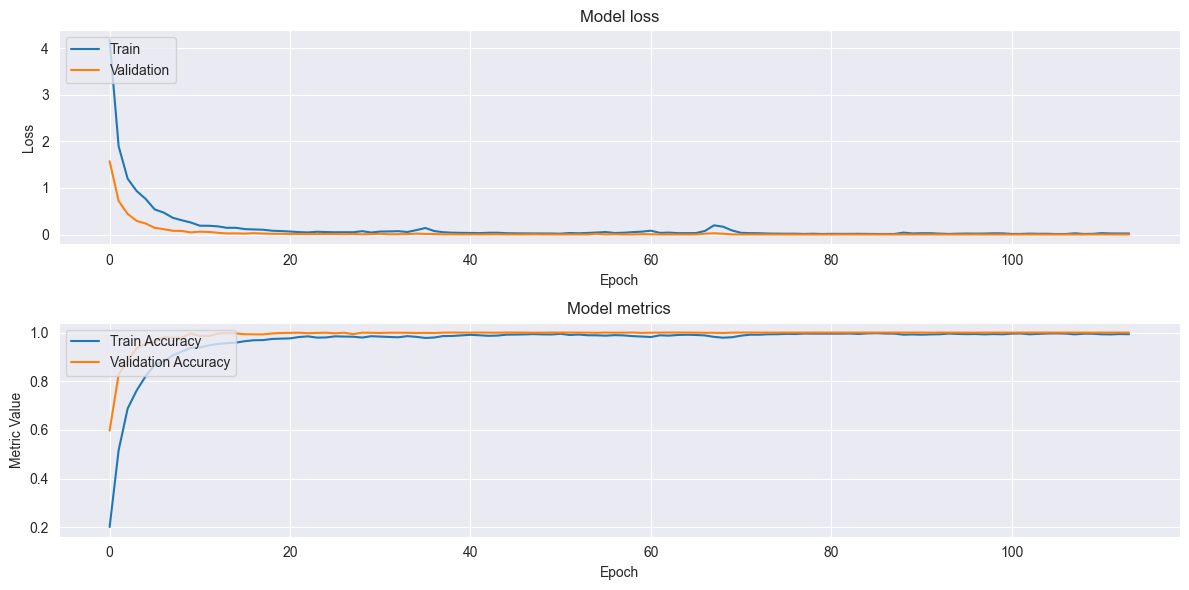

In [166]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()